In [1]:
import torch
from torchtext import data
from torchtext import datasets
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [2]:
# Why packed padded sequence?
# ans at https://www.cnblogs.com/sbj123456789/p/9834018.html

# batch.text will be: sentence(a numericalized tensor that has been padded) 
# and the second element being the actual lengths of our sentences.
TEXT=data.Field(include_lengths=True)
LABEL=data.LabelField(dtype=torch.float)

In [3]:
train_data,test_data=datasets.IMDB.splits(TEXT,LABEL)

In [4]:
import random
train_data,valid_data=train_data.split(random_state = random.seed(SEED))

In [5]:
type(train_data)

torchtext.data.dataset.Dataset

In [6]:
len(train_data)

17500

In [7]:
MAX_VOCAB_SIZE=25000
# unk_init的作用是将在字典中但是不在预训练词向量中的词向量采用高斯分布随机初始化
# TEXT.build_vocab(train, vectors=GloVe(name='6B', dim=100)) 
TEXT.build_vocab(train_data,
                max_size=MAX_VOCAB_SIZE,
                vectors="glove.6B.100d",
                unk_init=torch.Tensor.normal_)
LABEL.build_vocab(train_data)

In [8]:
TEXT.vocab.stoi

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x000002A7F22C7748>>,
            {'<unk>': 0,
             '<pad>': 1,
             'the': 2,
             'a': 3,
             'and': 4,
             'of': 5,
             'to': 6,
             'is': 7,
             'in': 8,
             'I': 9,
             'that': 10,
             'this': 11,
             'it': 12,
             '/><br': 13,
             'was': 14,
             'as': 15,
             'with': 16,
             'for': 17,
             'The': 18,
             'but': 19,
             'on': 20,
             'movie': 21,
             'are': 22,
             'his': 23,
             'film': 24,
             'have': 25,
             'not': 26,
             'be': 27,
             'you': 28,
             'he': 29,
             'by': 30,
             'at': 31,
             'one': 32,
             'an': 33,
             'from': 34,
             'who': 35,
             'like': 36,
             '

In [9]:
BATCH_SIZE=64
device=torch.device('cuda' if torch.cuda.is_available else 'cpu')
train_iterator,valid_iterator,test_iterator=data.BucketIterator.splits(
    (train_data,valid_data,test_data),
    batch_size=BATCH_SIZE,
    sort_within_batch=True,
    device=device)

In [10]:
batch=next(iter(train_iterator))

In [11]:
batch.text[0][:,0].shape

torch.Size([114])

In [12]:
batch.label.shape

torch.Size([64])

In [13]:
batch=next(iter(train_iterator))
' '.join(TEXT.vocab.itos[i] for i in batch.text[0][:,0])

'I remember seeing this film when it first came out in 1982 & loved it then. About 4 years later I had the privilege of seeing Luciano Pavarotti sing at the <unk> Opera house in New York (in <unk> so seeing the ending of this film reminds me very much of that great night. What\'s not to like about this film? The music is brilliant and Pavarotti <unk> was at his best and still looked great. The story is actually very funny in parts & the <unk> <unk> scene is still one of the funniest I have ever seen. The hot air balloon flight over the <unk> valley was beautiful & so was the song he sang "If we were in love" (one of the few times Pavarotti sang in <unk> And hearing the duet of Santa <unk> gorgeous. Get real folks, this was a film about an opera singer called <unk> <unk> who just happened to be played by <unk> Kathryn <unk> & Eddie Albert were excellent in their supporting roles.<br /><br />I am VERY glad that I still have this almost worn out VHS tape of this movie but I would love thi

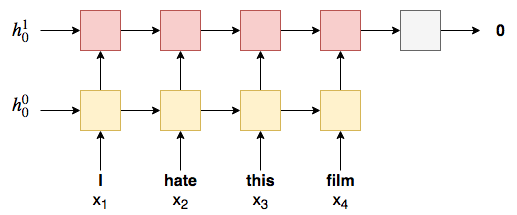

In [14]:
from IPython.display import Image
Image(filename = 'C:/Users/sins0/Desktop/Multi-layer RNN.png')

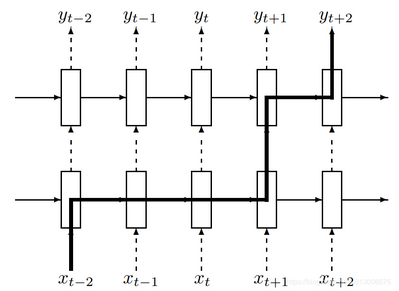

In [15]:
Image(filename = 'C:/Users/sins0/Desktop/LSTMDropOut.png')

In [16]:
# 很TM抽象，矩阵的mother fucking空间结构！！！！

# 做个2层BiLSTM的笔记：
# output=[sent len,batch size,num_directions * hidden_size],最后一层所有隐藏元的值
# h=[num_layers * num_directions, batch size, hidden_size]，所有层最后一个时间步的值

# 获取反向的最后一个output：output_last = output[:,0,-128:]
# 获反向最后一层的h：h[-1]
# 反向最后的output等于最后一层的h

# 获取正向的最后一个output：output_last = output[:,-1,:128]
# 获取正向最后一层的h：h[-2]
# 正向最后的output等于最后一层的h

In [17]:
import torch.nn as nn
class RNN(nn.Module):
    def __init__(self,vocab_size,embedding_dim,hidden_dim,output_dim,n_layers,
                bidirectional,dropout,pad_idx):
        super().__init__()
        
        # 重要的一步！遇到padding_idx后进行0填充
        self.embedding=nn.Embedding(vocab_size,embedding_dim,padding_idx=pad_idx)
            
        # a Dropout layer on the outputs of each LSTM layer except the last layer
        self.rnn=nn.LSTM(input_size=embedding_dim,
                         hidden_size=hidden_dim,
                         num_layers=n_layers,
                         bidirectional=bidirectional,
                         dropout=dropout)
        
        self.fc=nn.Linear(hidden_dim*2,output_dim)
        self.dropout=nn.Dropout(dropout)
    def forward(self,text,text_lengths):
        # text:[sent len,batch size]
        embedded=self.dropout(self.embedding(text))
        #embedded:[sent len,batch size,emb dim]
        
        # pack sequence
        packed_embedded=nn.utils.rnn.pack_padded_sequence(embedded,text_lengths)
        packed_output,(hidden,cell)=self.rnn(packed_embedded)
        
        # unpack sequence,an inverse operation to pack_padded_sequence()
        output,output_length=nn.utils.rnn.pad_packed_sequence(packed_output)
        # output:[sent len,batch size,num_directions * hidden_size]
        # output over padding tokens are zero tensors
        
        # hidden:[num_layers * num_directions, batch size, hidden_size]
        # ///////////////////////////////////////////////////////////////
        # hidden order: [forward_layer_0, backward_layer_0, 
        #                forward_layer_1, backward_layer 1,
        #                               ..., 
        #                forward_layer_n, backward_layer n]
        # ///////////////////////////////////////////////////////////////
        # cell:[num_layers * num_directions, batch size, hidden_size]
        
        # concat the final forward(hidden[-2,:,:]) and backward(hidden[-1,:,:])hidden layers
        # and apply dropout
        hidden=self.dropout(torch.cat((hidden[-2],hidden[-1]),dim=1))
        # hidden:[batch size,hid dim*num directions]
        
        return self.fc(hidden)        

In [18]:
INPUT_DIM=len(TEXT.vocab)
EMBEDDING_DIM=100
HIDDEN_DIM=256
OUTPUT_DIM=1
N_LAYERS=2
BIDIRECTIONAL=True
DROPOUT=0.5
# get pad token index from the vocabulary,getting the actual string representing 
# the pad token from the field's pad_token attribute, which is <pad> by default.
PAD_IDX=TEXT.vocab.stoi[TEXT.pad_token]

model=RNN(INPUT_DIM,
          EMBEDDING_DIM,
          HIDDEN_DIM,
          OUTPUT_DIM,
          N_LAYERS,
          BIDIRECTIONAL,
          DROPOUT,
          PAD_IDX)

In [19]:
model

RNN(
  (embedding): Embedding(25002, 100, padding_idx=1)
  (rnn): LSTM(100, 256, num_layers=2, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [20]:
pretrained_embeddings=TEXT.vocab.vectors
print(pretrained_embeddings.shape)

torch.Size([25002, 100])


In [21]:
# then replace the initial weights of the embedding layer with the pre-trained embeddings
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 1.8546, -1.5614,  1.3588,  ...,  0.3140, -1.2461, -0.7104],
        [-0.9722,  0.4570,  0.3754,  ...,  0.1021,  0.4910, -2.2479],
        [ 0.4946, -0.3538,  0.1981,  ..., -0.0276,  1.3616,  0.7029]])

In [22]:
UNK_IDX=TEXT.vocab.stoi[TEXT.unk_token]
model.embedding.weight.data[UNK_IDX]=torch.zeros(EMBEDDING_DIM)
PAD_IDX=TEXT.vocab.stoi[TEXT.pad_token]
model.embedding.weight.data[PAD_IDX]=torch.zeros(EMBEDDING_DIM)
print(model.embedding.weight.data)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 1.8546, -1.5614,  1.3588,  ...,  0.3140, -1.2461, -0.7104],
        [-0.9722,  0.4570,  0.3754,  ...,  0.1021,  0.4910, -2.2479],
        [ 0.4946, -0.3538,  0.1981,  ..., -0.0276,  1.3616,  0.7029]])


In [23]:
import torch.optim as optim
# 提供的参数更新频率越高，学习率越低，而参数更新频率越低，学习率就越高。
optimizer=optim.Adam(model.parameters())

In [24]:
# 把Sigmoid和BCELoss合成一步
criterion=nn.BCEWithLogitsLoss()

model=model.to(device)
criterion=criterion.to(device)

In [25]:
def binary_accuracy(preds,y):
    # Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    # round predictions to the closest integer
    rounded_preds=torch.round(torch.sigmoid(preds))
    correct=(rounded_preds==y).float() # convert into float for division 
    acc=correct.sum()/len(correct)
    return acc

In [26]:
# TEXT.lable.shape=torch.Size([64]),predictions的第二维度如果是1就去掉
def train(model,iterator,optimizer,criterion):
    epoch_loss=0
    epoch_acc=0
    model.train()
    for batch in iterator:
        optimizer.zero_grad()
        text,text_lengths=batch.text
        predictions=model(text,text_lengths).squeeze(1)
        loss=criterion(predictions,batch.label)
        acc=binary_accuracy(predictions,batch.label)
        loss.backward()
        optimizer.step()
        epoch_loss+=loss.item()
        epoch_acc+=acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [27]:
# TEXT.lable.shape=torch.Size([64]),predictions的第二维度如果是1就去掉
def evaluate(model,iterator,criterion):
    epoch_loss=0
    epoch_acc=0
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            text,text_lengths=batch.text
            predictions=model(text,text_lengths).squeeze(1)
            loss=criterion(predictions,batch.label)
            acc=binary_accuracy(predictions,batch.label)
            epoch_loss+=loss.item()
            epoch_acc+=acc.item()
        return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [28]:
import time
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS=5
for epoch in range(N_EPOCHS):
    start_time=time.time()
    
    train_loss,train_acc=train(model,train_iterator,optimizer,criterion)
    valid_loss,valid_acc=evaluate(model,train_iterator,criterion)
    
    end_time=time.time()
    
    epoch_mins,epoch_secs=epoch_time(start_time,end_time)
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')